In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp.analysis.apogee_analysis import subgiants
import seaborn as sns
from surp.analysis import gce_math as gcem
import surp

from surp._globals import AGB_MODELS
import arya
import scipy

modified solar abundances via mag++22


In [2]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "S16/W18": 120,
    "S16/W18F": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "LC18", "S16/W18F", "S16/W18", "NKT13", "WW95"]
colors = [arya.style.COLORS[i] for i in [0,0,1,1,2,3,4]]
markers = ["o", "o", "s", "d", "*", "^"]
sizes = [30, 30,30, 30,30,30]
rotations = [0, 300, 0, 0, 0, 0]
N = len(ccsne_studies)

labels = [r"LC18, $v_{\rm rot}=0\;{\rm km\,s^{-1}}$", 
          r"LC18, $v_{\rm rot}=300\;{\rm km\,s^{-1}}$",
          "S16/All explode", 
          "S16/W18", 
          "NKT13", 
          "WW95"]


def plot_analy():
    m_h = np.linspace(-5, 1, 1000)
    Z = gcem.MH_to_Z(m_h)
    plt.plot(m_h, y_c_cc(Z), color="k", ls="-", zorder=-2, label="Analytic")
    plt.plot(m_h, y_c_cc2(Z), color="k", ls="--", zorder=-2)

    
def plot_c11():
    vice.yields.agb.settings["c"] = "cristallo11"
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)

    MoverH_min = gcem.Z_to_MH(min(Zs))
    MoverH_max = gcem.Z_to_MH(max(Zs))

    MH = np.linspace(MoverH_min, MoverH_max, 100)
    Zs = gcem.MH_to_Z(MH)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1]/1e6)
    line, = plt.plot(MH, (np.array(mass_yields)), label="C11 (AGB)", color=colors[-1])



In [3]:
def plot_y_cc(ele='c', ele2=None):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        m_upper = M_max[study]

        rotation = rotations[i]

        y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        if ele2 is not None:
            y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity, 
                rotation=rotation, m_upper=m_upper)[0]
                 for metalicity in metalicities])
            y = np.log10(y/y2) - np.log10(vice.solar_z(ele)/vice.solar_z(ele2))

        marker = markers[i]
        color =facecolor= colors[i]
        label = labels[i]
        if np.isinf(metalicities[0]):
            if study == "WW95":
                x0 = -4.5
                y0 = -0.000
                ms = 5
                zorder = 2
            else:
                x0 = -4.5
                y0 = 0
                ms = 6
                zorder = 3
            plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                         xuplims=[1],ms=ms, zorder=zorder, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities

        if rotation == 150:
            facecolor=(1,1,1,0)
        if rotation == 300:
            facecolor=(1,1,1,0)

        plt.scatter(x, y, ec=color, label=label,
                    lw=1, fc=facecolor, 
                     marker=marker, s=sizes[i])


In [4]:
surp.yields.set_yields()


y_c_cc = vice.yields.ccsne.settings["c"]

Yield settings
X       CC                            agb                           SN Ia
c       2.28e-03 + 5.28e-02 (Z - Z0)  1.36 × cristallo11            0
n       5.00e-04                      0.00e+00 M + 5.02e-04 M Z/Z0  6.43e-09
o       7.13e-03                      0                             0
mg      6.52e-04                      0                             0
fe      4.73e-04                      0                             7.70e-04




In [6]:
surp.yields.set_yields(log_cc=True)
y_c_cc2 = vice.yields.ccsne.settings["c"]

Yield settings
X       CC                            agb                           SN Ia
c       8.45e-04 + 7.50e-04 (Z-Z0) + 6.5e-04(Z-Z0)^21.36 × cristallo11            0
n       5.00e-04                      0.00e+00 M + 5.02e-04 M Z/Z0  6.43e-09
o       7.13e-03                      0                             0
mg      6.52e-04                      0                             0
fe      4.73e-04                      0                             7.70e-04




/tmp/slurmtmp.24252288/ipykernel_134833/804337447.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/slurmtmp.24252288/ipykernel_134833/804337447.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


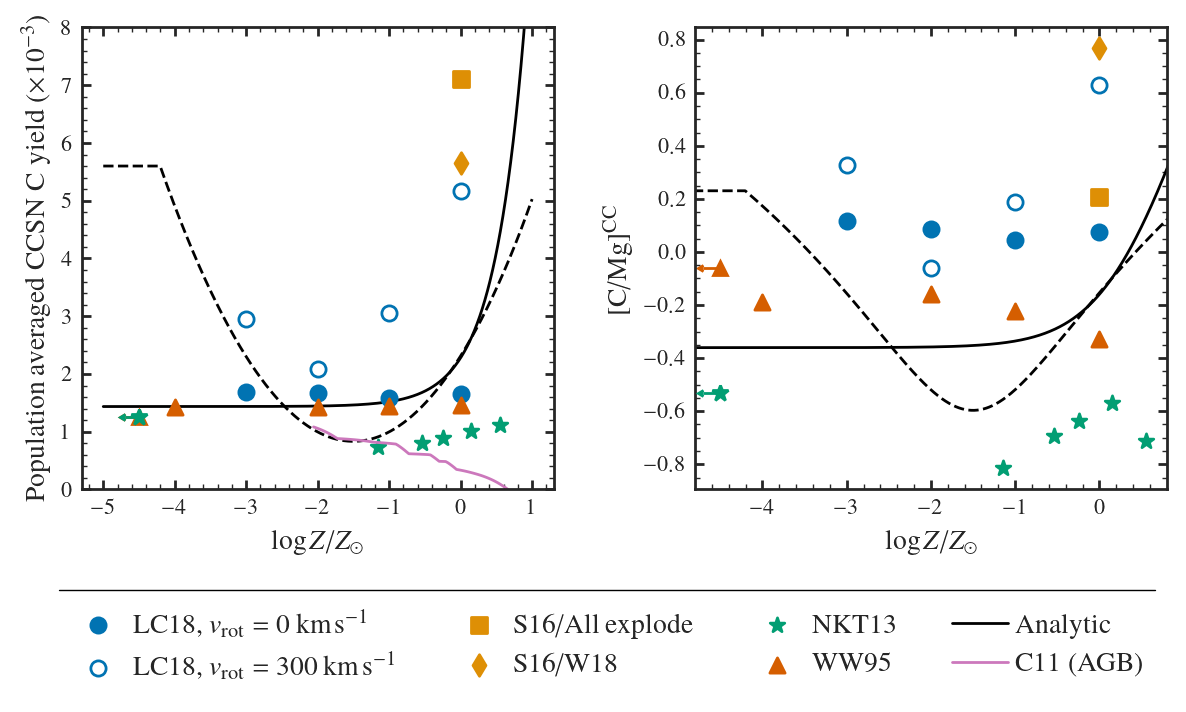

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={"wspace": 0.3})


plt.sca(axs[0])

plot_y_cc()

plot_analy()
plot_c11()
# plot AGB line
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"Population averaged CCSN C yield ($\times 10^{-3}$)")

plt.ylim(0, 0.008)

lines, labels = axs[0].get_legend_handles_labels()

c = np.arange(0, 0.0081, 0.001)
plt.yticks(ticks=c, labels=np.int32(1e3*c))


plt.sca(axs[1])

plot_y_cc(ele2="mg")


m_h = np.linspace(-5, 1, 1000)
Z = surp.analysis.MH_to_Z(m_h)
y_mg = vice.yields.ccsne.settings["mg"]
y = gcem.abundance_to_bracket(y_c_cc(Z)/y_mg, "c", "mg")
plt.plot(m_h, y, color="k")

y = gcem.abundance_to_bracket(y_c_cc2(Z)/y_mg, "c", "mg")
plt.plot(m_h, y, color="k", ls="--")

# final style things
lab = plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")
plt.xlim(-4.8, 0.8)



    
leg = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


# plt.legend(handles =l, bbox_to_anchor=(0,-0.2), loc="upper left")
fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))

plt.savefig("figures/cc_yields.pdf")

In [15]:
np.int32(2.0)

2